Numero di file audio trovati: 1950


Normalizzazione degli audio: 100%|██████████| 1950/1950 [00:00<00:00, 8601.51it/s]


Numero di file audio normalizzati: 1950


Suddivisione degli audio: 100%|██████████| 1950/1950 [00:00<00:00, 27675.15it/s]


Numero di file audio segmentati: 7811


Generazione degli spettrogrammi:   2%|▏         | 153/7811 [00:07<06:05, 20.95it/s]


KeyboardInterrupt: 

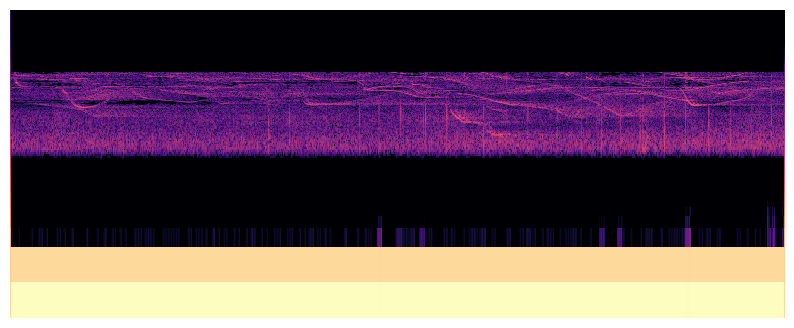

In [2]:
import os
import json
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa.display
from tqdm import tqdm
from pydub import AudioSegment
import gc
import psutil

# Definizione delle directory di input e output
input_dir = 'Dataset1'
normalized_output_dir = 'NuovoDataset/Normalized'
segmented_output_dir = 'NuovoDataset/Segmented'
spectrogram_output_dir = 'NuovoDataset/Spectrograms'

# Creare le directory di output se non esistono
os.makedirs(normalized_output_dir, exist_ok=True)
os.makedirs(segmented_output_dir, exist_ok=True)
os.makedirs(spectrogram_output_dir, exist_ok=True)

# Definizione della lunghezza desiderata in secondi e in campioni
desired_length_sec = 4  # Durata desiderata in secondi
sampling_rate = 192000  # Frequenza di campionamento (modifica se necessario)
desired_length_samples = int(desired_length_sec * sampling_rate)

# File di checkpoint
normalized_checkpoint_file = 'normalized_files.json'
segmented_checkpoint_file = 'segmented_files.json'
spectrogram_checkpoint_file = 'spectrogram_files.json'

# Funzioni per caricare e salvare le liste di checkpoint
def load_checkpoint(filepath):
    if os.path.exists(filepath):
        with open(filepath, 'r') as f:
            return set(json.load(f))
    return set()

def save_checkpoint(processed_files, filepath):
    with open(filepath, 'w') as f:
        json.dump(list(processed_files), f)

# Carica i checkpoint
normalized_files = load_checkpoint(normalized_checkpoint_file)
segmented_files = load_checkpoint(segmented_checkpoint_file)
spectrogram_files = load_checkpoint(spectrogram_checkpoint_file)

# Lista per memorizzare i percorsi dei file audio
audio_files = []
# Scorrere ricorsivamente le cartelle nel dataset
for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.endswith('.wav') or file.endswith('.mp3'):
            audio_files.append(os.path.join(root, file))

# Visualizzare il numero di file audio trovati
print(f"Numero di file audio trovati: {len(audio_files)}")

def normalize_audio(input_file, output_file):
    # Carica il file audio
    audio_data, sample_rate = librosa.load(input_file, sr=None)
    
    # Trova il valore massimo assoluto nel segnale audio
    max_val = np.max(np.abs(audio_data))
    
    # Normalizza il segnale tra 0 e 1
    normalized_audio = (audio_data / max_val + 1) / 2
    
    # Scrivi il file audio normalizzato
    sf.write(output_file, normalized_audio, sample_rate)

# Normalizzare tutti i file audio e salvarli nella directory di output corrispondente
for file in tqdm(audio_files, desc='Normalizzazione degli audio'):
    relative_path = os.path.relpath(file, input_dir)
    output_file = os.path.join(normalized_output_dir, relative_path)
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    
    if file not in normalized_files:
        normalize_audio(file, output_file)
        normalized_files.add(file)
        save_checkpoint(normalized_files, normalized_checkpoint_file)

audio_norm = []

# Scorrere ricorsivamente le cartelle nel dataset normalizzato
for root, dirs, files in os.walk(normalized_output_dir):
    for file in files:
        if file.endswith('.wav') or file.endswith('.mp3'):
            audio_norm.append(os.path.join(root, file))

# Visualizzare il numero di file audio trovati
print(f"Numero di file audio normalizzati: {len(audio_norm)}")

def split_audio(input_file, output_directory, segment_duration=4):
    # Carica il file audio
    audio_data, sample_rate = librosa.load(input_file, sr=None)
    
    # Calcola il numero di campioni per ogni segmento
    segment_samples = int(segment_duration * sample_rate)
    
    # Ottieni il nome del file originale senza estensione
    original_filename = os.path.splitext(os.path.basename(input_file))[0]
    
    # Inizializza il contatore per i segmenti
    segment_counter = 0
    
    # Itera attraverso l'audio e salva i segmenti
    for start in range(0, len(audio_data), segment_samples):
        end = start + segment_samples
        segment_data = audio_data[start:end]
        
        # Costruisci il nome del file per il segmento
        segment_filename = f"{original_filename}_segment_{segment_counter}.wav"
        output_file = os.path.join(output_directory, segment_filename)
        
        # Crea la directory di output se non esiste
        os.makedirs(output_directory, exist_ok=True)
        
        # Scrivi il file audio del segmento
        sf.write(output_file, segment_data, sample_rate)
        
        # Incrementa il contatore dei segmenti
        segment_counter += 1

# Dividere tutti i file audio normalizzati in segmenti e salvarli nella directory di output corrispondente
for file in tqdm(audio_norm, desc='Suddivisione degli audio'):
    relative_path = os.path.relpath(file, normalized_output_dir)
    output_directory = os.path.join(segmented_output_dir, os.path.dirname(relative_path))
    
    if file not in segmented_files:
        split_audio(file, output_directory)
        segmented_files.add(file)
        save_checkpoint(segmented_files, segmented_checkpoint_file)

audio_segmented = []

# Scorrere ricorsivamente le cartelle nel dataset segmentato
for root, dirs, files in os.walk(segmented_output_dir):
    for file in files:
        if file.endswith('.wav') or file.endswith('.mp3'):
            audio_segmented.append(os.path.join(root, file))

# Visualizzare il numero di file audio trovati
print(f"Numero di file audio segmentati: {len(audio_segmented)}")

memory_threshold = 0.8  # Soglia di memoria (80%)

def generate_spectrogram(file, output_folder):
    # Controlla l'estensione del file
    if file.endswith('.mp3'):
        audio = AudioSegment.from_mp3(file).set_frame_rate(sampling_rate).set_channels(1)
        y = np.array(audio.get_array_of_samples(), dtype=np.float32)
        sr = audio.frame_rate
    else:  # file.endswith('.wav')
        y, sr = sf.read(file, always_2d=False)
        if len(y.shape) > 1:  # Se stereo, converte in mono
            y = librosa.to_mono(y.T)
        y = librosa.resample(y, orig_sr=sr, target_sr=sampling_rate)
        sr = sampling_rate
    
    # Calcola lo spettrogramma STFT
    D = np.abs(librosa.stft(y))  # Magnitude of the STFT
    D_db = librosa.amplitude_to_db(D, ref=np.max)
    
    # Creare la struttura delle directory di output mantenendo la stessa gerarchia
    relative_path = os.path.relpath(file, segmented_output_dir)
    segment_output_dir = os.path.dirname(os.path.join(output_folder, relative_path))
    os.makedirs(segment_output_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(file))[0]
    spectrogram_output_file = os.path.join(segment_output_dir, f"{base_name}_spectrogram.png")
        
    # Salva lo spettrogramma come immagine
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D_db, sr=sr, x_axis='time', y_axis='log')
    plt.axis('off')  # Disabilita gli assi
    plt.savefig(spectrogram_output_file, bbox_inches='tight', pad_inches=0)
    plt.close()

def check_memory_and_cleanup():
    memory_usage = psutil.virtual_memory().percent
    if memory_usage > memory_threshold * 100:
        gc.collect()

# Generare spettrogrammi per tutti i file audio segmentati e salvarli nella directory di output corrispondente
with tqdm(total=len(audio_segmented), desc='Generazione degli spettrogrammi') as pbar:
    for file in audio_segmented:
        if file not in spectrogram_files:
            generate_spectrogram(file, spectrogram_output_dir)
            spectrogram_files.add(file)
            save_checkpoint(spectrogram_files, spectrogram_checkpoint_file)
        check_memory_and_cleanup()
        pbar.update(1)

print("Processo completato.")
